Copyright 2021 Takehiro Ajioka

### Enviroment

Python 3.6
Anaconda
tensorflow-gpu==1.15.0
keras==2.3.1
shap==0.36.0
tfdeterminism==0.3.0

In [1]:
# Ignore warning
import os
import tensorflow as tf
import logging
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)

In [2]:
import numpy
import pandas
import matplotlib.pyplot as plt
from scipy import io
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, ConvLSTM2D, Bidirectional
from sklearn.metrics import roc_curve
from sklearn.metrics import auc, roc_auc_score

In [3]:
# Allow grouth option of GPU
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [4]:
# Load data
signal = io.loadmat('../data/signal_5mice.mat')
runrest = io.loadmat('../data/runrest_5mice.mat')

In [5]:
plt.rcParams["font.size"] = 18

# Preprocess

In [6]:
# Mini-max normalization
def mini_max(dataset):
    min_value = dataset.min(axis=0)
    max_value = dataset.max(axis=0)
    dataset_nor = (dataset - min_value) / (max_value - min_value)
    return dataset_nor

In [7]:
# Create input data [-n,n+1]
def create_dataset(dataset, look_frame):
    dataX, dataY = [], []
    for i in range(look_frame,len(dataset)-(look_frame)):
        xset = []
        for j in range(dataset.shape[1]-1):
            a = dataset[(i-look_frame):(i+look_frame+1), j]
            xset.append(a)
        dataY.append(dataset[i, -1])      
        dataX.append(xset)
    return numpy.array(dataX), numpy.array(dataY)

In [8]:
look_frame = 15 #read the previous and next n frames as input

def Data_preprocess(signal, runrest):
    # Normalize
    signal = mini_max(signal.transpose())
    runrest = runrest.transpose()
    # Create dataset
    dataset = numpy.hstack([signal.astype('float32'), runrest.astype('float32')])
    X, Y = create_dataset(dataset, look_frame)
    return X, Y

In [9]:
def Get_Dataset(TEST):
    print('TEST')
    # Test dataset
    testX = numpy.empty([0,50,31], dtype=numpy.float32)
    testY = numpy.empty(0, dtype=numpy.float32)
    for i in TEST:
        print(f'Mouse {i}')
        for j in range(signal['signal'+str(i)].shape[1]):
            X, Y = Data_preprocess(signal['signal'+str(i)][0,j], runrest['runrest'+str(i)][0,j])
            testX = numpy.concatenate([testX, X], axis=0)
            testY = numpy.concatenate([testY, Y], axis=0)

    return testX, testY

# Evaluate

In [10]:
import itertools

In [11]:
Models = ['LSTM', 'GRU', 'RNN', 'BiLSTM', 'BiGRU', 'BiRNN']

In [12]:
# Plot ROC curve
def plot_roc(y_pred, y_test, mode):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    AUC = roc_auc_score(y_test, y_pred)
    plt.plot(fpr, tpr, label="AUC = {:.3f}".format(AUC))
    plt.title(mode + " ROC curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()
    print('AUC: {:.3f}'.format(AUC))
    opt_thr = thresholds[numpy.argmax(tpr - fpr)]
    print('Optimal threshold: {:.3f}'.format(opt_thr))
    return AUC

TEST
Mouse 1


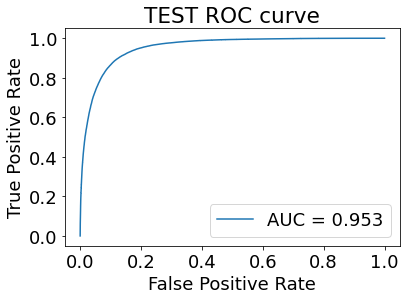

AUC: 0.953
Optimal threshold: 0.082
197670/197670 [==============================] - 72s 363us/sample - loss: 0.3605 - acc: 0.8482


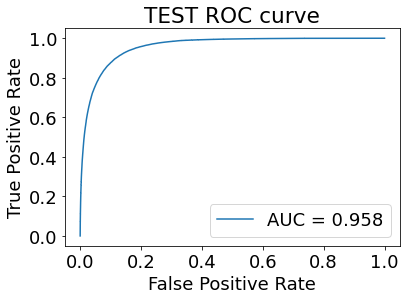

AUC: 0.958
Optimal threshold: 0.316
197670/197670 [==============================] - 64s 326us/sample - loss: 0.2553 - acc: 0.8914


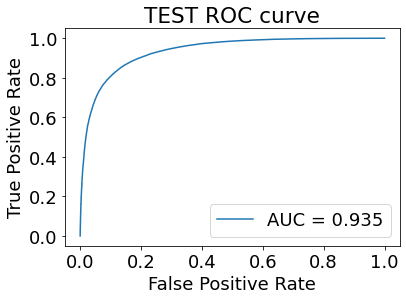

AUC: 0.935
Optimal threshold: 0.281
197670/197670 [==============================] - 26s 130us/sample - loss: 0.3193 - acc: 0.8662


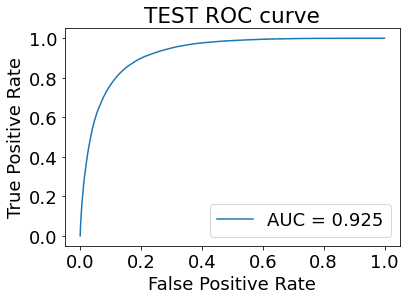

AUC: 0.925
Optimal threshold: 0.732
197670/197670 [==============================] - 117s 590us/sample - loss: 0.5047 - acc: 0.8183


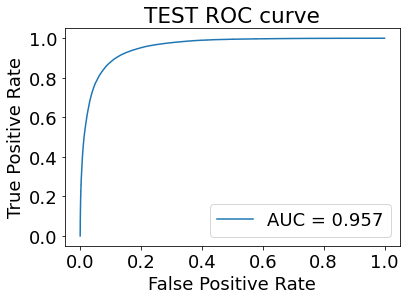

AUC: 0.957
Optimal threshold: 0.348
197670/197670 [==============================] - 96s 488us/sample - loss: 0.2582 - acc: 0.8938


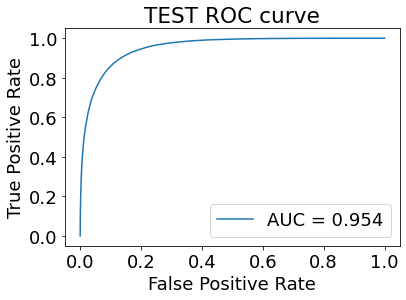

AUC: 0.954
Optimal threshold: 0.197
197670/197670 [==============================] - 48s 241us/sample - loss: 0.2894 - acc: 0.8697
TEST
Mouse 1


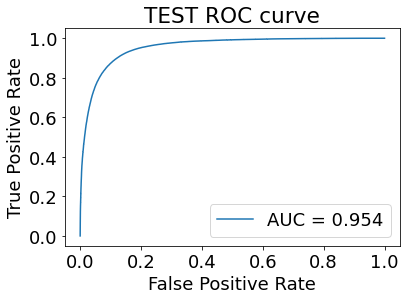

AUC: 0.954
Optimal threshold: 0.192
197670/197670 [==============================] - 71s 357us/sample - loss: 0.2798 - acc: 0.8815


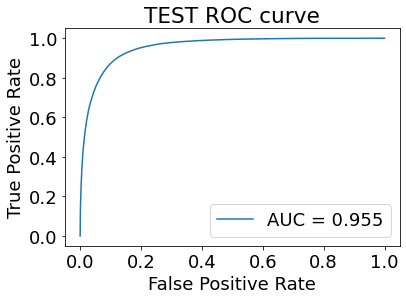

AUC: 0.955
Optimal threshold: 0.109
197670/197670 [==============================] - 50s 251us/sample - loss: 0.3364 - acc: 0.8531


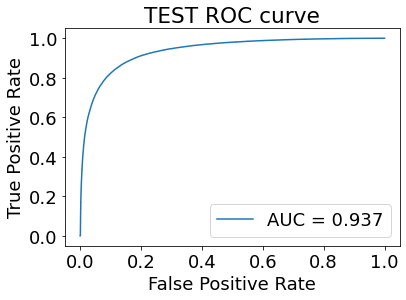

AUC: 0.937
Optimal threshold: 0.299
197670/197670 [==============================] - 31s 158us/sample - loss: 0.3109 - acc: 0.8711


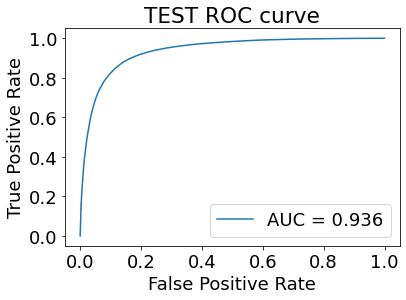

AUC: 0.936
Optimal threshold: 0.138
197670/197670 [==============================] - 117s 590us/sample - loss: 0.3696 - acc: 0.8635


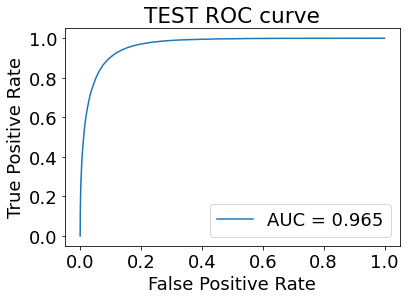

AUC: 0.965
Optimal threshold: 0.165
197670/197670 [==============================] - 94s 475us/sample - loss: 0.2583 - acc: 0.8889


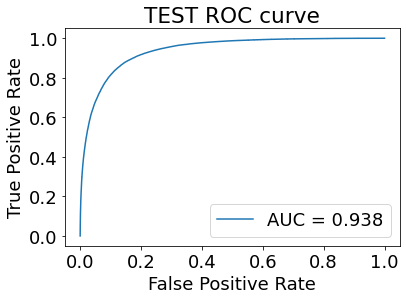

AUC: 0.938
Optimal threshold: 0.142
197670/197670 [==============================] - 49s 248us/sample - loss: 0.3553 - acc: 0.8433
TEST
Mouse 1


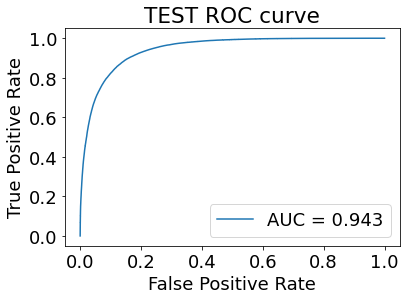

AUC: 0.943
Optimal threshold: 0.166
197670/197670 [==============================] - 71s 357us/sample - loss: 0.3228 - acc: 0.8643


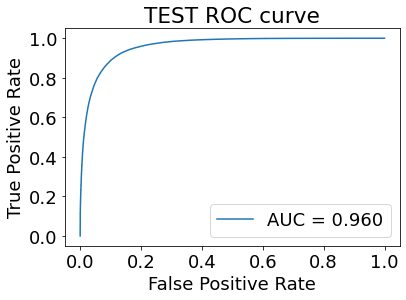

AUC: 0.960
Optimal threshold: 0.104
197670/197670 [==============================] - 61s 309us/sample - loss: 0.3264 - acc: 0.8559


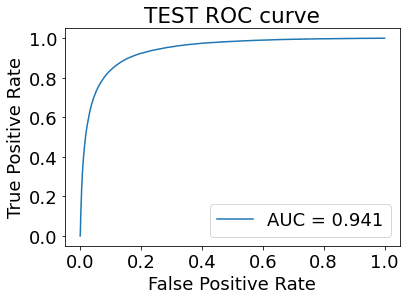

AUC: 0.941
Optimal threshold: 0.356
197670/197670 [==============================] - 33s 167us/sample - loss: 0.3014 - acc: 0.8783


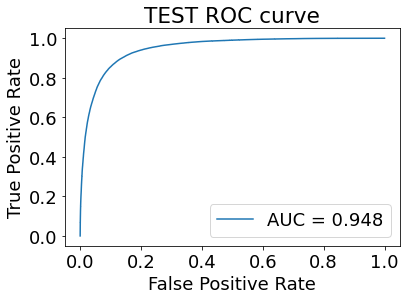

AUC: 0.948
Optimal threshold: 0.131
197670/197670 [==============================] - 118s 599us/sample - loss: 0.3335 - acc: 0.8671


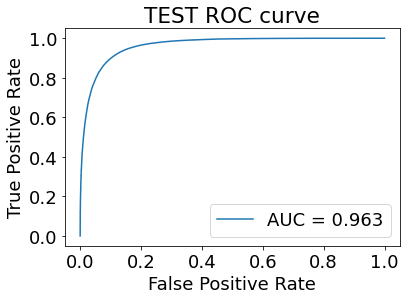

AUC: 0.963
Optimal threshold: 0.140
197670/197670 [==============================] - 96s 486us/sample - loss: 0.3046 - acc: 0.8631


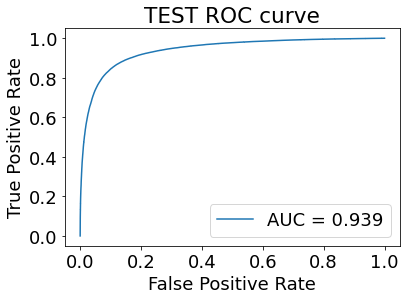

AUC: 0.939
Optimal threshold: 0.155
197670/197670 [==============================] - 48s 241us/sample - loss: 0.3627 - acc: 0.8440
TEST
Mouse 1


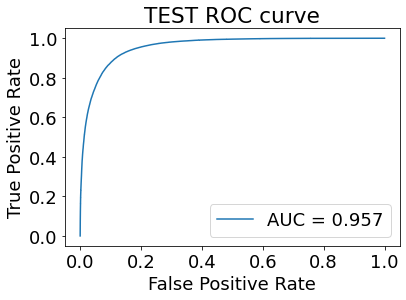

AUC: 0.957
Optimal threshold: 0.060
197670/197670 [==============================] - 69s 347us/sample - loss: 0.4012 - acc: 0.8289


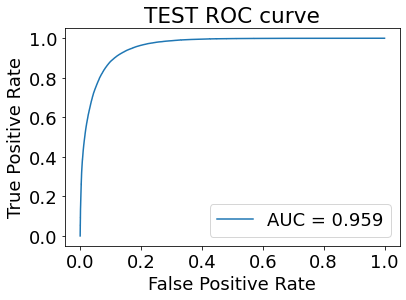

AUC: 0.959
Optimal threshold: 0.073
197670/197670 [==============================] - 61s 309us/sample - loss: 0.3449 - acc: 0.8524


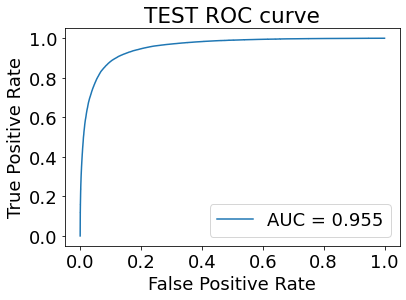

AUC: 0.955
Optimal threshold: 0.183
197670/197670 [==============================] - 34s 173us/sample - loss: 0.2926 - acc: 0.8781


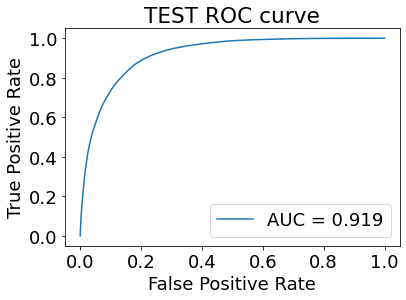

AUC: 0.919
Optimal threshold: 0.426
197670/197670 [==============================] - 107s 541us/sample - loss: 0.4033 - acc: 0.8397


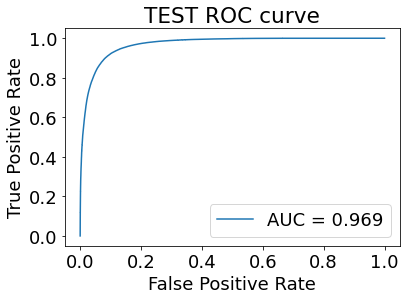

AUC: 0.969
Optimal threshold: 0.102
197670/197670 [==============================] - 85s 432us/sample - loss: 0.2902 - acc: 0.8734


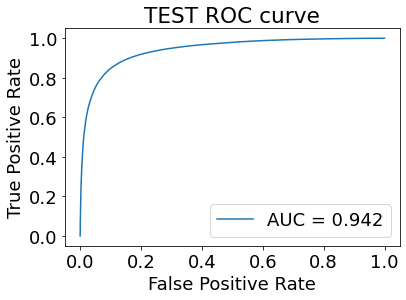

AUC: 0.942
Optimal threshold: 0.198
197670/197670 [==============================] - 31s 158us/sample - loss: 0.3271 - acc: 0.8746
TEST
Mouse 2


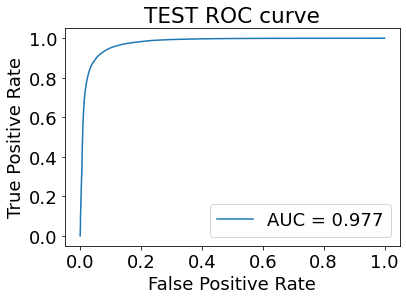

AUC: 0.977
Optimal threshold: 0.521
215640/215640 [==============================] - 61s 283us/sample - loss: 0.1837 - acc: 0.9309


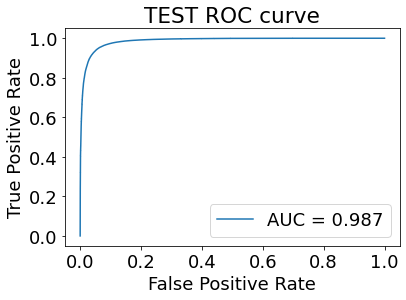

AUC: 0.987
Optimal threshold: 0.551
215640/215640 [==============================] - 53s 248us/sample - loss: 0.1443 - acc: 0.9485


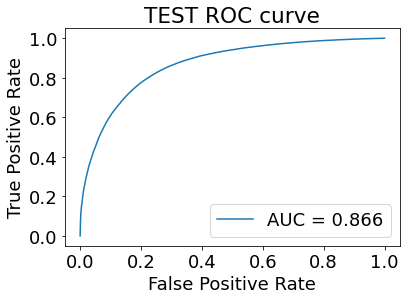

AUC: 0.866
Optimal threshold: 0.360
215640/215640 [==============================] - 22s 103us/sample - loss: 0.5697 - acc: 0.7697


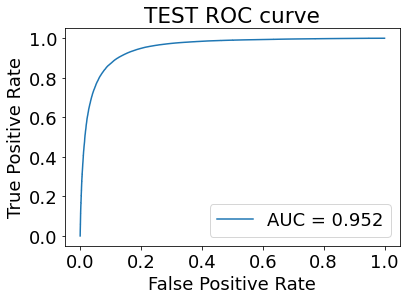

AUC: 0.952
Optimal threshold: 0.253
215640/215640 [==============================] - 109s 506us/sample - loss: 0.3760 - acc: 0.8690


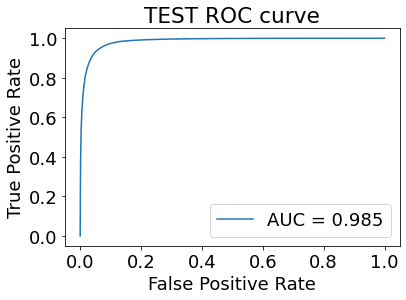

AUC: 0.985
Optimal threshold: 0.637
215640/215640 [==============================] - 94s 435us/sample - loss: 0.1460 - acc: 0.9482


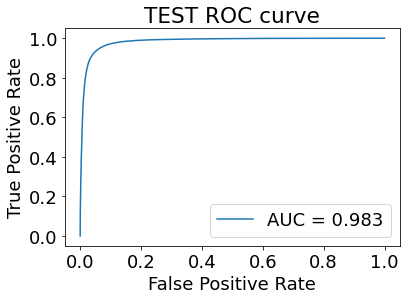

AUC: 0.983
Optimal threshold: 0.584
215640/215640 [==============================] - 35s 163us/sample - loss: 0.1485 - acc: 0.9470
TEST
Mouse 2


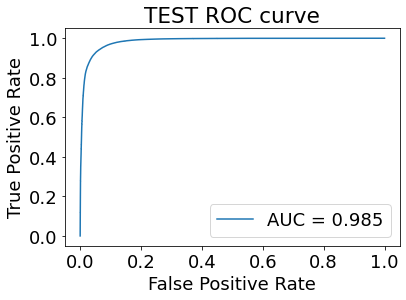

AUC: 0.985
Optimal threshold: 0.504
215640/215640 [==============================] - 63s 290us/sample - loss: 0.1547 - acc: 0.9420


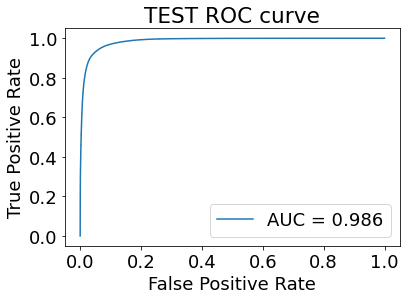

AUC: 0.986
Optimal threshold: 0.439
215640/215640 [==============================] - 54s 251us/sample - loss: 0.1625 - acc: 0.9404


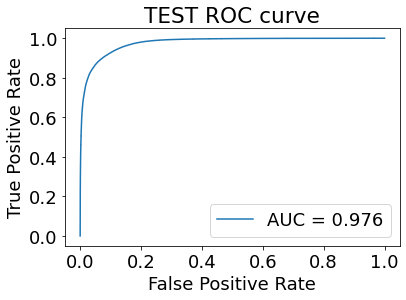

AUC: 0.976
Optimal threshold: 0.312
215640/215640 [==============================] - 24s 111us/sample - loss: 0.2475 - acc: 0.9024


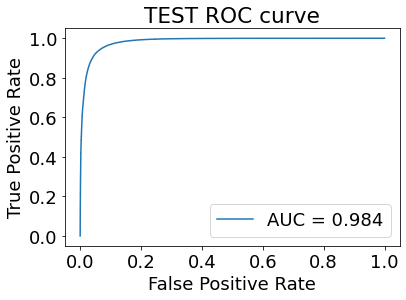

AUC: 0.984
Optimal threshold: 0.529
215640/215640 [==============================] - 109s 507us/sample - loss: 0.1659 - acc: 0.9413


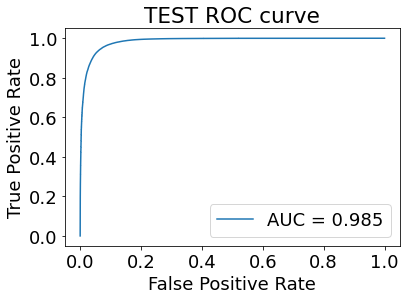

AUC: 0.985
Optimal threshold: 0.395
215640/215640 [==============================] - 95s 440us/sample - loss: 0.1665 - acc: 0.9393


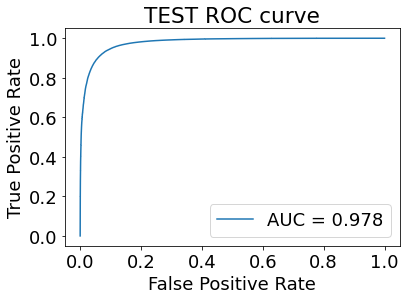

AUC: 0.978
Optimal threshold: 0.469
215640/215640 [==============================] - 36s 165us/sample - loss: 0.1893 - acc: 0.9257
TEST
Mouse 2


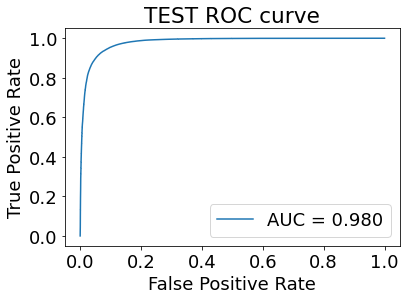

AUC: 0.980
Optimal threshold: 0.404
215640/215640 [==============================] - 64s 295us/sample - loss: 0.2022 - acc: 0.9249


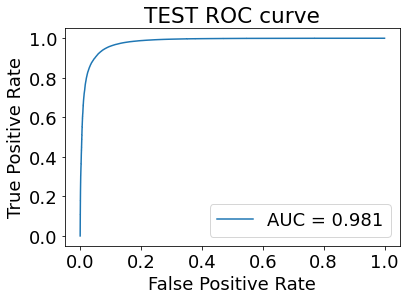

AUC: 0.981
Optimal threshold: 0.363
215640/215640 [==============================] - 55s 255us/sample - loss: 0.1944 - acc: 0.9239


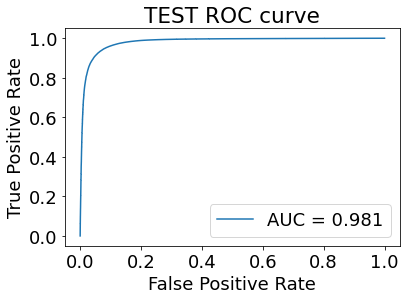

AUC: 0.981
Optimal threshold: 0.398
215640/215640 [==============================] - 24s 112us/sample - loss: 0.1784 - acc: 0.9318


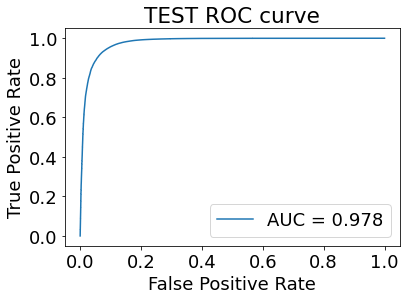

AUC: 0.978
Optimal threshold: 0.247
215640/215640 [==============================] - 113s 523us/sample - loss: 0.2268 - acc: 0.9130


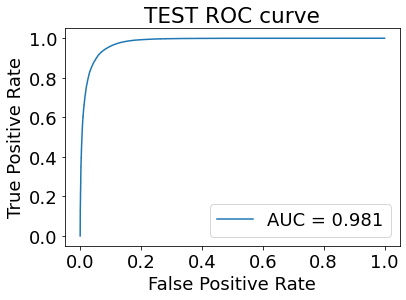

AUC: 0.981
Optimal threshold: 0.401
215640/215640 [==============================] - 98s 454us/sample - loss: 0.1841 - acc: 0.9292


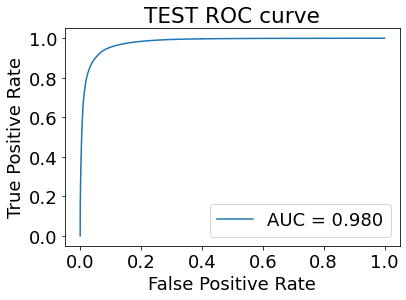

AUC: 0.980
Optimal threshold: 0.537
215640/215640 [==============================] - 39s 179us/sample - loss: 0.1771 - acc: 0.9347
TEST
Mouse 2


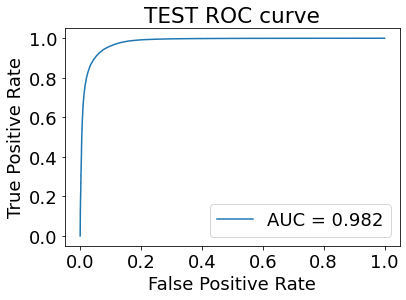

AUC: 0.982
Optimal threshold: 0.352
215640/215640 [==============================] - 68s 314us/sample - loss: 0.1931 - acc: 0.9278


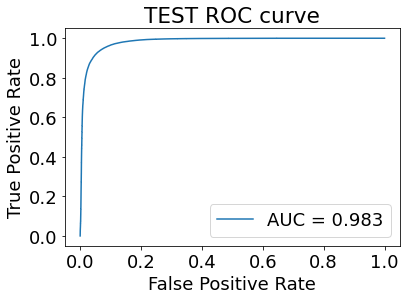

AUC: 0.983
Optimal threshold: 0.435
215640/215640 [==============================] - 59s 274us/sample - loss: 0.1713 - acc: 0.9353


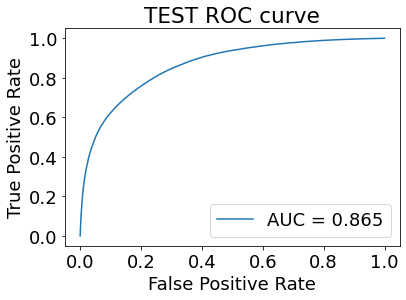

AUC: 0.865
Optimal threshold: 0.202
215640/215640 [==============================] - 27s 123us/sample - loss: 0.7151 - acc: 0.7396


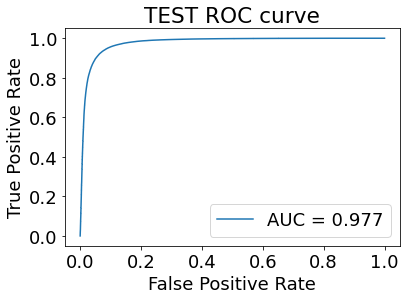

AUC: 0.977
Optimal threshold: 0.329
215640/215640 [==============================] - 114s 527us/sample - loss: 0.2269 - acc: 0.9163


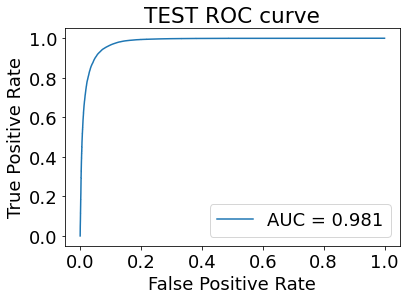

AUC: 0.981
Optimal threshold: 0.426
215640/215640 [==============================] - 100s 462us/sample - loss: 0.1777 - acc: 0.9336


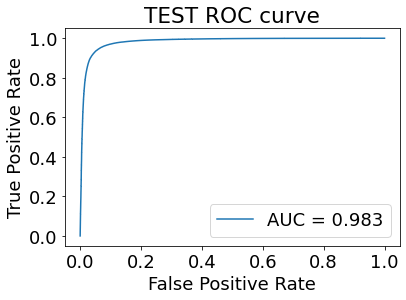

AUC: 0.983
Optimal threshold: 0.483
215640/215640 [==============================] - 39s 181us/sample - loss: 0.1630 - acc: 0.9425
TEST
Mouse 3


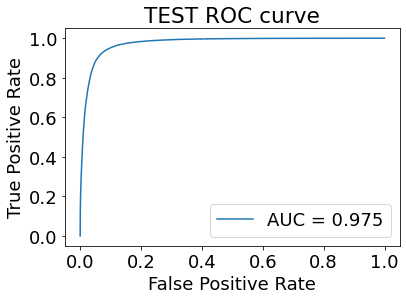

AUC: 0.975
Optimal threshold: 0.758
251580/251580 [==============================] - 80s 316us/sample - loss: 0.1872 - acc: 0.9317


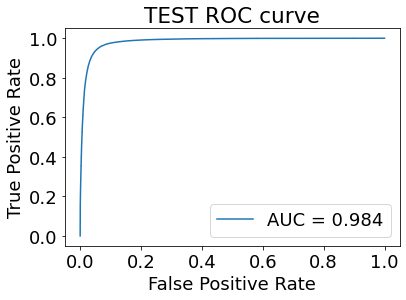

AUC: 0.984
Optimal threshold: 0.661
251580/251580 [==============================] - 67s 266us/sample - loss: 0.1499 - acc: 0.9492


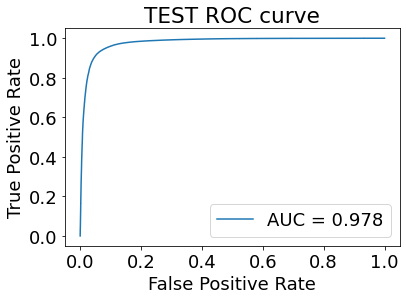

AUC: 0.978
Optimal threshold: 0.600
251580/251580 [==============================] - 30s 119us/sample - loss: 0.1718 - acc: 0.9380


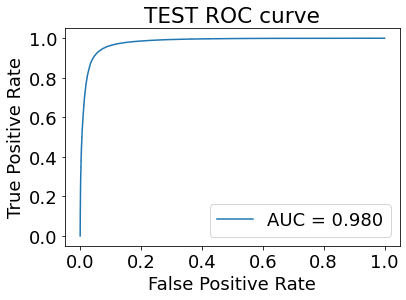

AUC: 0.980
Optimal threshold: 0.738
251580/251580 [==============================] - 133s 528us/sample - loss: 0.1691 - acc: 0.9392


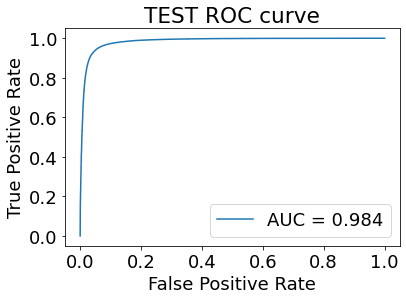

AUC: 0.984
Optimal threshold: 0.822
251580/251580 [==============================] - 114s 455us/sample - loss: 0.1604 - acc: 0.9417


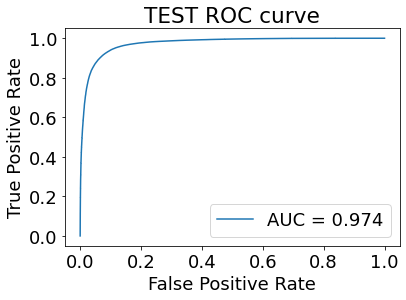

AUC: 0.974
Optimal threshold: 0.476
251580/251580 [==============================] - 45s 177us/sample - loss: 0.2021 - acc: 0.9228
TEST
Mouse 3


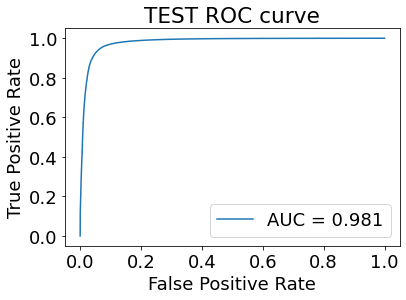

AUC: 0.981
Optimal threshold: 0.795
251580/251580 [==============================] - 78s 311us/sample - loss: 0.1698 - acc: 0.9395


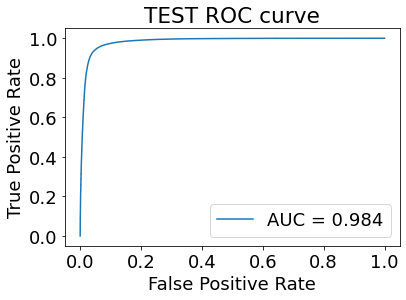

AUC: 0.984
Optimal threshold: 0.774
251580/251580 [==============================] - 68s 271us/sample - loss: 0.1478 - acc: 0.9471


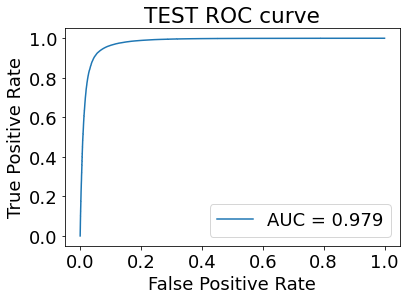

AUC: 0.979
Optimal threshold: 0.731
251580/251580 [==============================] - 31s 122us/sample - loss: 0.1660 - acc: 0.9394


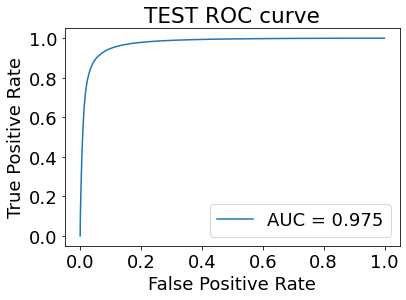

AUC: 0.975
Optimal threshold: 0.578
251580/251580 [==============================] - 133s 530us/sample - loss: 0.1885 - acc: 0.9309


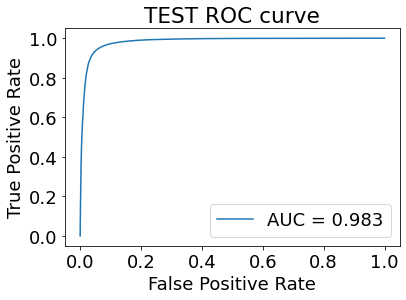

AUC: 0.983
Optimal threshold: 0.791
251580/251580 [==============================] - 116s 462us/sample - loss: 0.1526 - acc: 0.9459


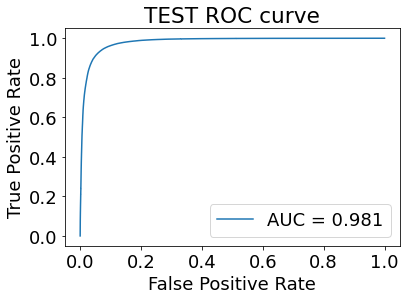

AUC: 0.981
Optimal threshold: 0.588
251580/251580 [==============================] - 46s 183us/sample - loss: 0.1625 - acc: 0.9404
TEST
Mouse 3


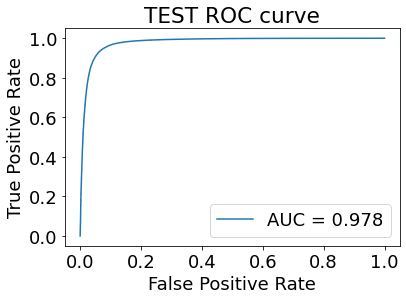

AUC: 0.978
Optimal threshold: 0.707
251580/251580 [==============================] - 80s 317us/sample - loss: 0.1705 - acc: 0.9425


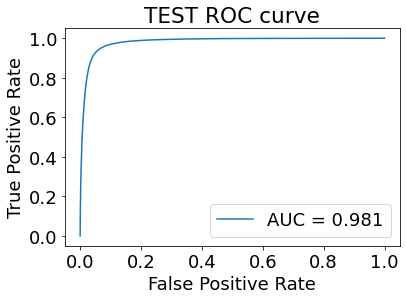

AUC: 0.981
Optimal threshold: 0.720
251580/251580 [==============================] - 69s 276us/sample - loss: 0.1580 - acc: 0.9448


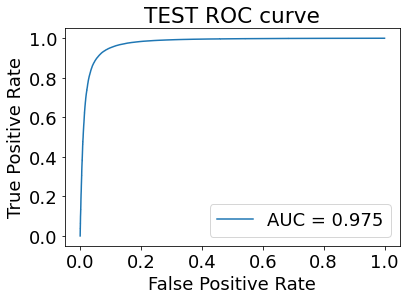

AUC: 0.975
Optimal threshold: 0.672
251580/251580 [==============================] - 27s 107us/sample - loss: 0.1841 - acc: 0.9340


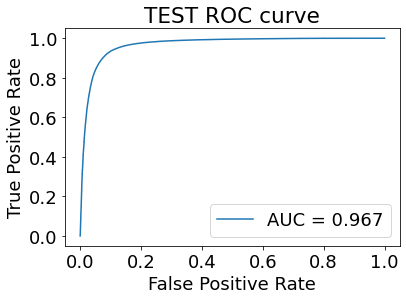

AUC: 0.967
Optimal threshold: 0.692
251580/251580 [==============================] - 134s 533us/sample - loss: 0.2167 - acc: 0.9239


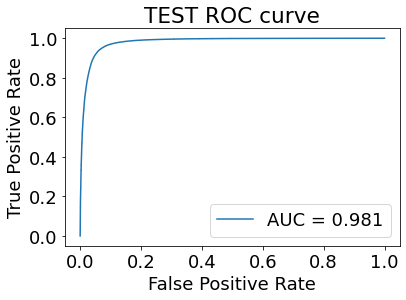

AUC: 0.981
Optimal threshold: 0.674
251580/251580 [==============================] - 116s 463us/sample - loss: 0.1594 - acc: 0.9453


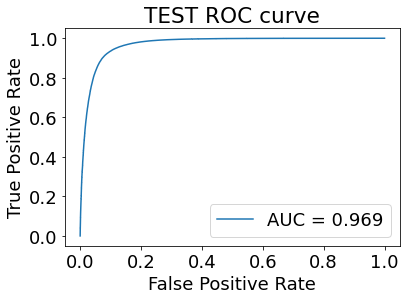

AUC: 0.969
Optimal threshold: 0.622
251580/251580 [==============================] - 47s 189us/sample - loss: 0.2006 - acc: 0.9261
TEST
Mouse 3


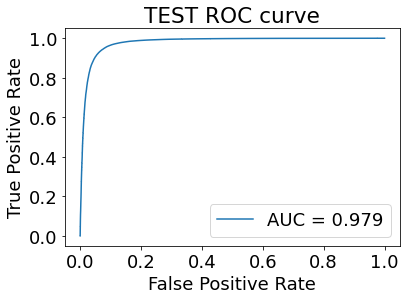

AUC: 0.979
Optimal threshold: 0.561
251580/251580 [==============================] - 81s 323us/sample - loss: 0.1664 - acc: 0.9414


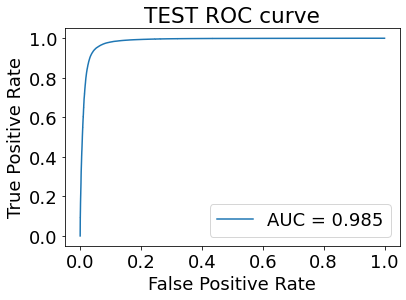

AUC: 0.985
Optimal threshold: 0.783
251580/251580 [==============================] - 71s 283us/sample - loss: 0.1385 - acc: 0.9529


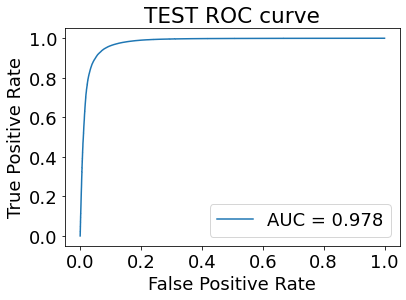

AUC: 0.978
Optimal threshold: 0.678
251580/251580 [==============================] - 33s 133us/sample - loss: 0.1671 - acc: 0.9401


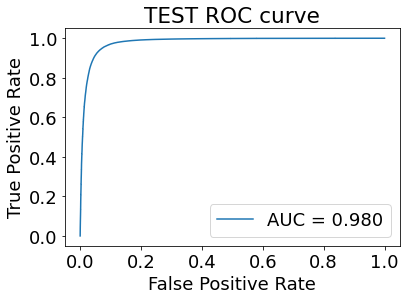

AUC: 0.980
Optimal threshold: 0.618
251580/251580 [==============================] - 135s 538us/sample - loss: 0.1575 - acc: 0.9456


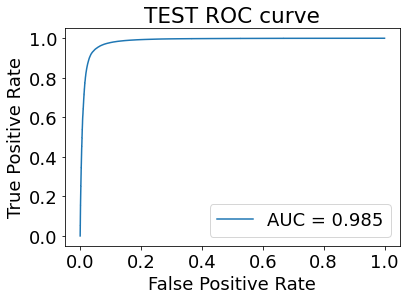

AUC: 0.985
Optimal threshold: 0.682
251580/251580 [==============================] - 117s 466us/sample - loss: 0.1375 - acc: 0.9524


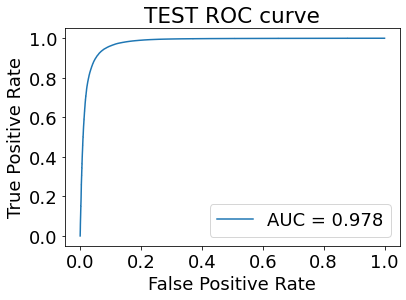

AUC: 0.978
Optimal threshold: 0.584
251580/251580 [==============================] - 49s 193us/sample - loss: 0.1684 - acc: 0.9392
TEST
Mouse 4


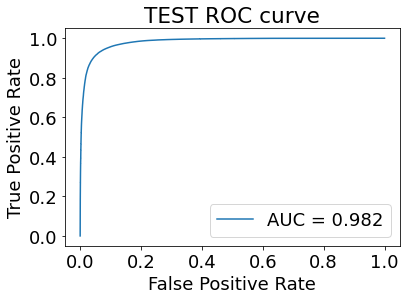

AUC: 0.982
Optimal threshold: 0.661
269550/269550 [==============================] - 81s 301us/sample - loss: 0.1789 - acc: 0.9342


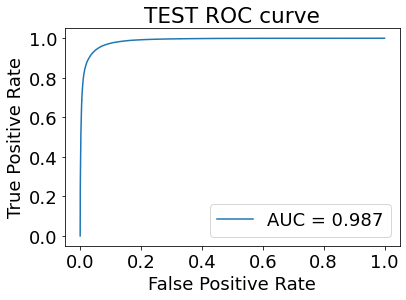

AUC: 0.987
Optimal threshold: 0.742
269550/269550 [==============================] - 77s 284us/sample - loss: 0.1507 - acc: 0.9456


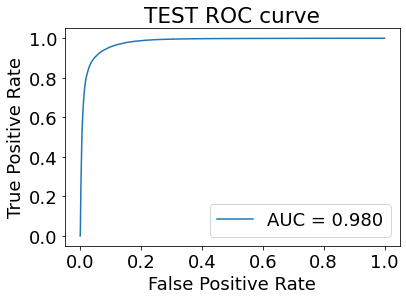

AUC: 0.980
Optimal threshold: 0.688
269550/269550 [==============================] - 37s 136us/sample - loss: 0.1741 - acc: 0.9329


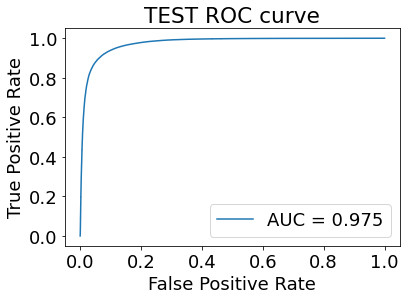

AUC: 0.975
Optimal threshold: 0.621
269550/269550 [==============================] - 146s 543us/sample - loss: 0.2098 - acc: 0.9227


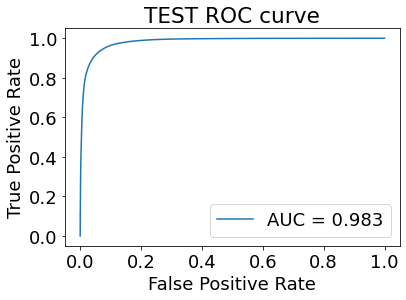

AUC: 0.983
Optimal threshold: 0.552
269550/269550 [==============================] - 129s 477us/sample - loss: 0.1649 - acc: 0.9370


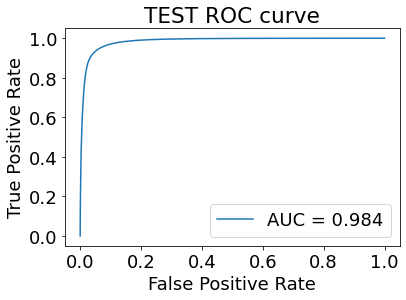

AUC: 0.984
Optimal threshold: 0.701
269550/269550 [==============================] - 53s 198us/sample - loss: 0.1544 - acc: 0.9431
TEST
Mouse 4


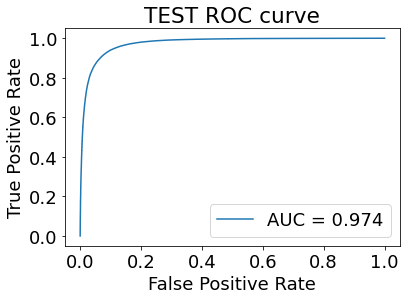

AUC: 0.974
Optimal threshold: 0.529
269550/269550 [==============================] - 90s 333us/sample - loss: 0.2059 - acc: 0.9223


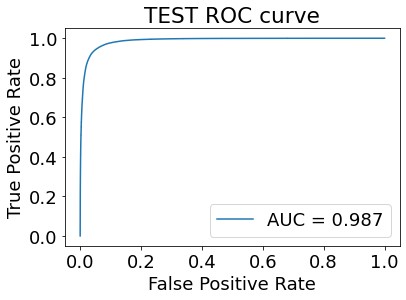

AUC: 0.987
Optimal threshold: 0.774
269550/269550 [==============================] - 78s 290us/sample - loss: 0.1470 - acc: 0.9460


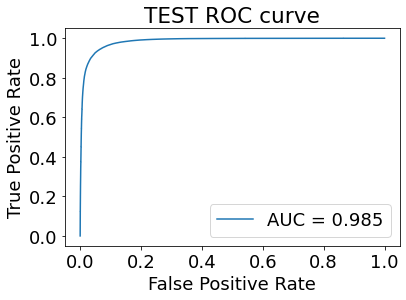

AUC: 0.985
Optimal threshold: 0.667
269550/269550 [==============================] - 38s 140us/sample - loss: 0.1548 - acc: 0.9410


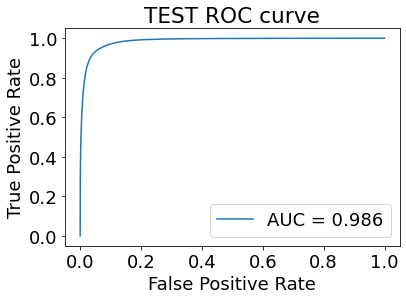

AUC: 0.986
Optimal threshold: 0.717
269550/269550 [==============================] - 149s 551us/sample - loss: 0.1534 - acc: 0.9426


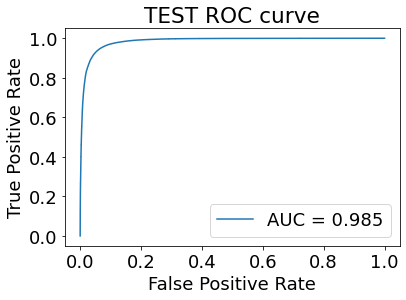

AUC: 0.985
Optimal threshold: 0.617
269550/269550 [==============================] - 128s 475us/sample - loss: 0.1529 - acc: 0.9433


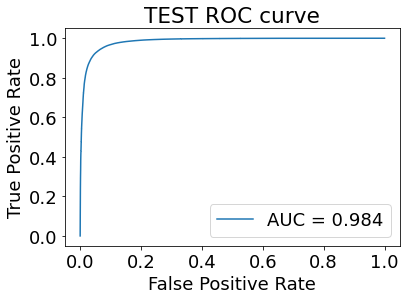

AUC: 0.984
Optimal threshold: 0.755
269550/269550 [==============================] - 55s 204us/sample - loss: 0.1678 - acc: 0.9379
TEST
Mouse 4


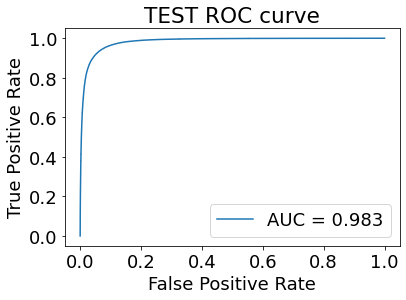

AUC: 0.983
Optimal threshold: 0.477
269550/269550 [==============================] - 90s 336us/sample - loss: 0.1726 - acc: 0.9366


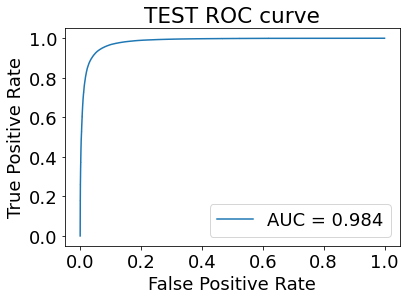

AUC: 0.984
Optimal threshold: 0.637
269550/269550 [==============================] - 80s 296us/sample - loss: 0.1593 - acc: 0.9408


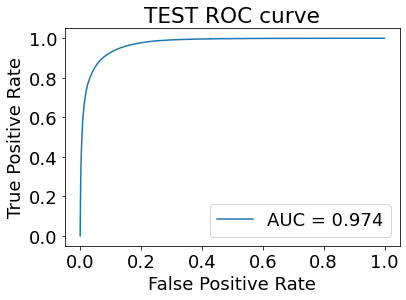

AUC: 0.974
Optimal threshold: 0.415
269550/269550 [==============================] - 39s 144us/sample - loss: 0.2175 - acc: 0.9123


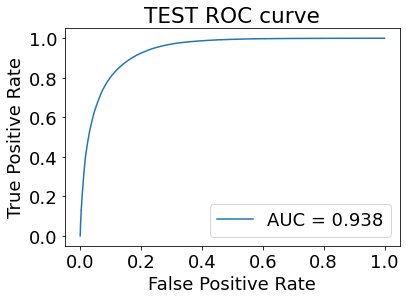

AUC: 0.938
Optimal threshold: 0.499
269550/269550 [==============================] - 149s 552us/sample - loss: 0.3321 - acc: 0.8698


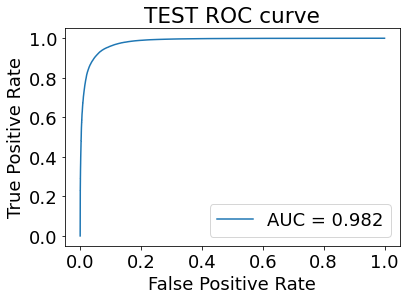

AUC: 0.982
Optimal threshold: 0.536
269550/269550 [==============================] - 130s 484us/sample - loss: 0.1769 - acc: 0.9352


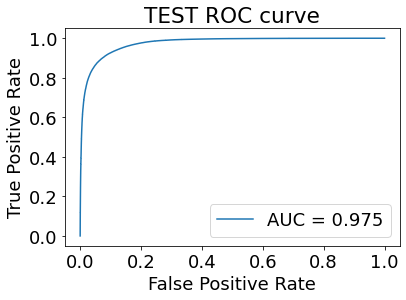

AUC: 0.975
Optimal threshold: 0.347
269550/269550 [==============================] - 56s 207us/sample - loss: 0.2395 - acc: 0.9092
TEST
Mouse 4


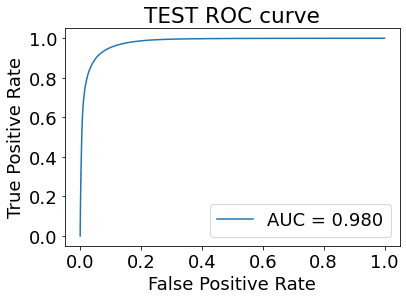

AUC: 0.980
Optimal threshold: 0.469
269550/269550 [==============================] - 88s 326us/sample - loss: 0.1866 - acc: 0.9295


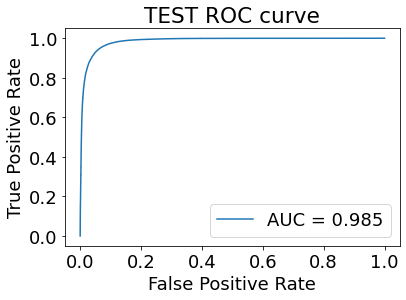

AUC: 0.985
Optimal threshold: 0.521
269550/269550 [==============================] - 82s 305us/sample - loss: 0.1481 - acc: 0.9444


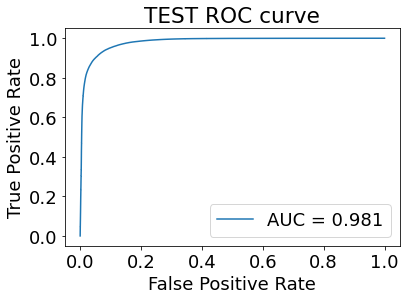

AUC: 0.981
Optimal threshold: 0.359
269550/269550 [==============================] - 41s 151us/sample - loss: 0.1951 - acc: 0.9250


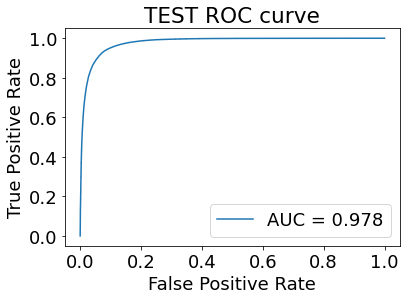

AUC: 0.978
Optimal threshold: 0.410
269550/269550 [==============================] - 153s 566us/sample - loss: 0.1992 - acc: 0.9248


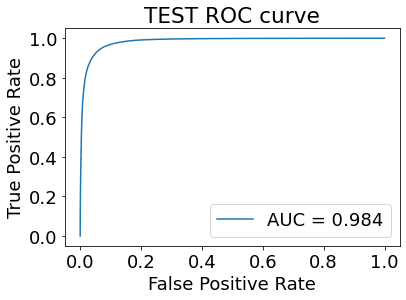

AUC: 0.984
Optimal threshold: 0.532
269550/269550 [==============================] - 133s 495us/sample - loss: 0.1606 - acc: 0.9416


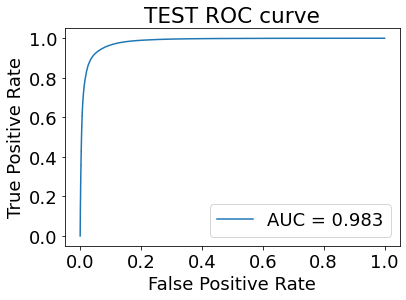

AUC: 0.983
Optimal threshold: 0.503
269550/269550 [==============================] - 58s 217us/sample - loss: 0.1714 - acc: 0.9380
TEST
Mouse 5


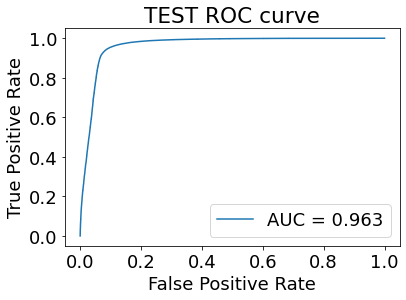

AUC: 0.963
Optimal threshold: 0.897
215640/215640 [==============================] - 74s 341us/sample - loss: 0.1697 - acc: 0.9465


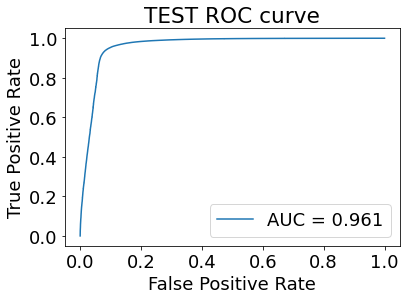

AUC: 0.961
Optimal threshold: 0.923
215640/215640 [==============================] - 68s 316us/sample - loss: 0.1754 - acc: 0.9421


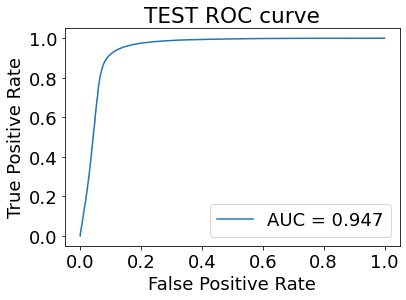

AUC: 0.947
Optimal threshold: 0.898
215640/215640 [==============================] - 34s 159us/sample - loss: 0.2032 - acc: 0.9281


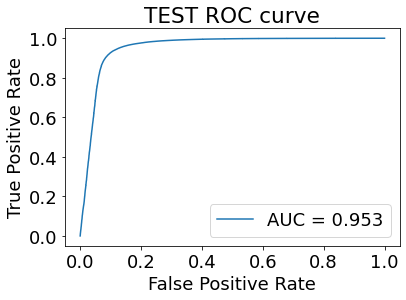

AUC: 0.953
Optimal threshold: 0.899
215640/215640 [==============================] - 123s 569us/sample - loss: 0.1944 - acc: 0.9406


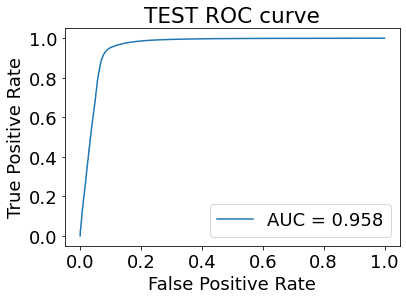

AUC: 0.958
Optimal threshold: 0.860
215640/215640 [==============================] - 107s 498us/sample - loss: 0.1599 - acc: 0.9506


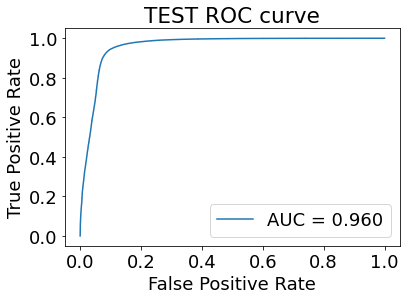

AUC: 0.960
Optimal threshold: 0.910
215640/215640 [==============================] - 48s 222us/sample - loss: 0.1693 - acc: 0.9444
TEST
Mouse 5


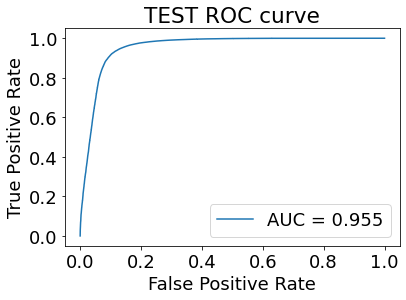

AUC: 0.955
Optimal threshold: 0.897
215640/215640 [==============================] - 75s 347us/sample - loss: 0.1883 - acc: 0.9416


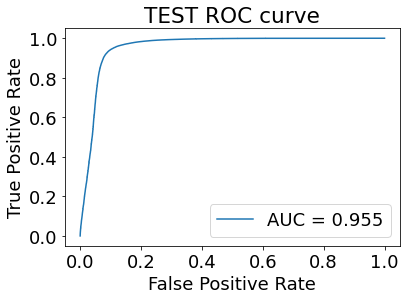

AUC: 0.955
Optimal threshold: 0.846
215640/215640 [==============================] - 68s 316us/sample - loss: 0.1665 - acc: 0.9480


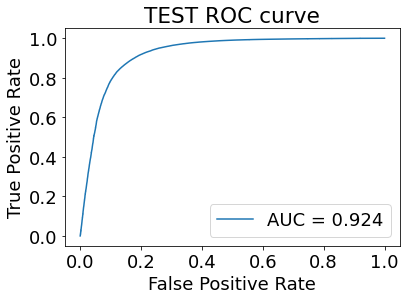

AUC: 0.924
Optimal threshold: 0.880
215640/215640 [==============================] - 35s 161us/sample - loss: 0.2565 - acc: 0.9100


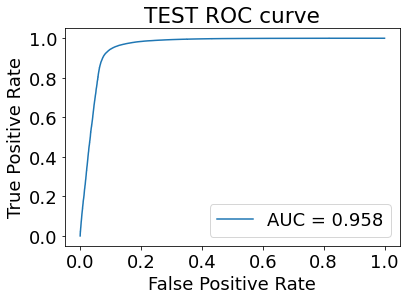

AUC: 0.958
Optimal threshold: 0.929
215640/215640 [==============================] - 125s 579us/sample - loss: 0.1811 - acc: 0.9457


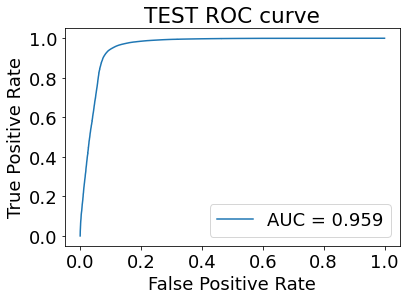

AUC: 0.959
Optimal threshold: 0.873
215640/215640 [==============================] - 109s 506us/sample - loss: 0.1660 - acc: 0.9496


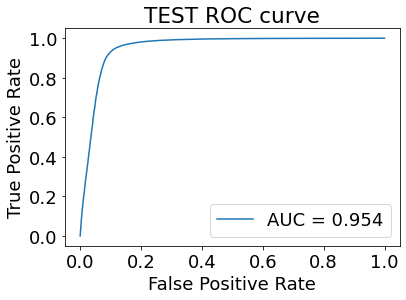

AUC: 0.954
Optimal threshold: 0.908
215640/215640 [==============================] - 48s 224us/sample - loss: 0.1827 - acc: 0.9430
TEST
Mouse 5


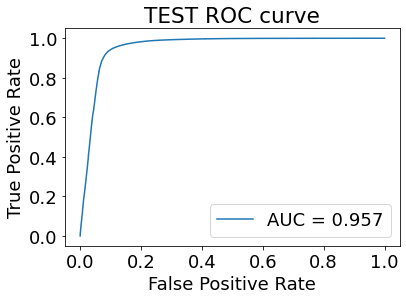

AUC: 0.957
Optimal threshold: 0.763
215640/215640 [==============================] - 76s 354us/sample - loss: 0.1694 - acc: 0.9467


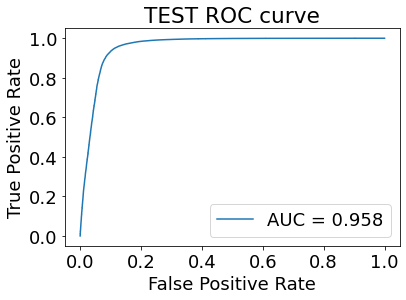

AUC: 0.958
Optimal threshold: 0.739
215640/215640 [==============================] - 70s 325us/sample - loss: 0.1659 - acc: 0.9481


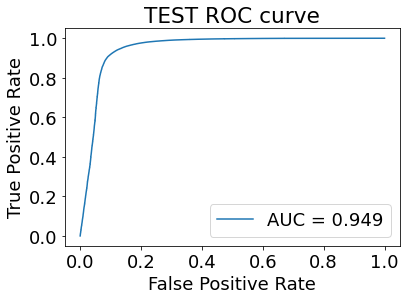

AUC: 0.949
Optimal threshold: 0.697
215640/215640 [==============================] - 36s 168us/sample - loss: 0.1842 - acc: 0.9377


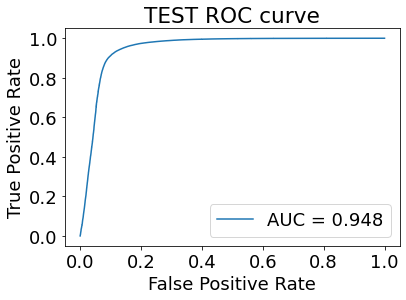

AUC: 0.948
Optimal threshold: 0.784
215640/215640 [==============================] - 125s 580us/sample - loss: 0.2036 - acc: 0.9385


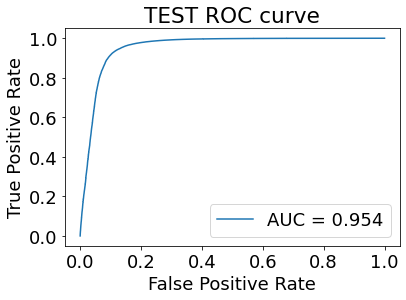

AUC: 0.954
Optimal threshold: 0.658
215640/215640 [==============================] - 110s 510us/sample - loss: 0.1864 - acc: 0.9396


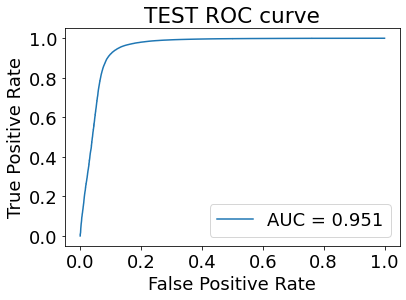

AUC: 0.951
Optimal threshold: 0.706
215640/215640 [==============================] - 50s 230us/sample - loss: 0.1837 - acc: 0.9426
TEST
Mouse 5


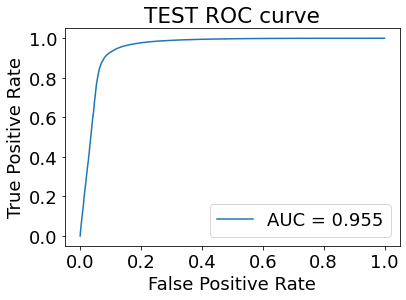

AUC: 0.955
Optimal threshold: 0.923
215640/215640 [==============================] - 77s 356us/sample - loss: 0.1963 - acc: 0.9366


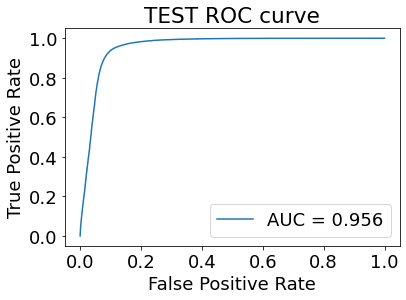

AUC: 0.956
Optimal threshold: 0.803
215640/215640 [==============================] - 72s 333us/sample - loss: 0.1661 - acc: 0.9473


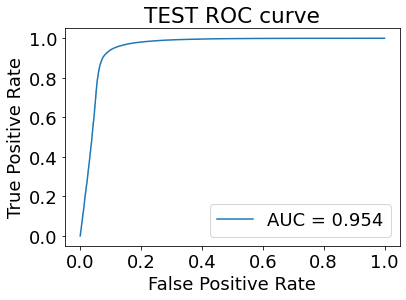

AUC: 0.954
Optimal threshold: 0.880
215640/215640 [==============================] - 38s 175us/sample - loss: 0.1757 - acc: 0.9418


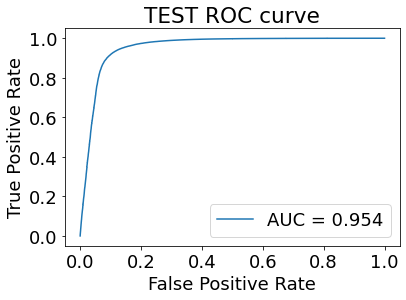

AUC: 0.954
Optimal threshold: 0.858
215640/215640 [==============================] - 127s 590us/sample - loss: 0.1900 - acc: 0.9396


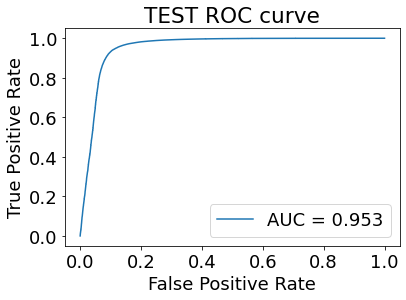

AUC: 0.953
Optimal threshold: 0.817
215640/215640 [==============================] - 111s 514us/sample - loss: 0.1738 - acc: 0.9466


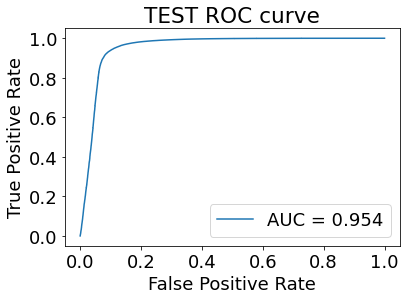

AUC: 0.954
Optimal threshold: 0.888
215640/215640 [==============================] - 51s 237us/sample - loss: 0.1741 - acc: 0.9463


In [13]:
df_AUC = pandas.DataFrame(numpy.zeros([20, 8]), columns=['VALID','TEST']+Models)
df_LOSS = pandas.DataFrame(numpy.zeros([20, 8]), columns=['VALID','TEST']+Models)
df_ACC = pandas.DataFrame(numpy.zeros([20, 8]), columns=['VALID','TEST']+Models)

l = [1, 2, 3, 4, 5]
for raw, v in enumerate(itertools.permutations(l, 2)):
    TEST = [v[0]]
    VALID = [v[1]]
    df_AUC['TEST'][raw] = df_LOSS['TEST'][raw] = df_ACC['TEST'][raw] = v[0]
    df_AUC['VALID'][raw] = df_LOSS['VALID'][raw] = df_ACC['VALID'][raw] = v[1]
    testX, testY = Get_Dataset(TEST)
    input_test = testX.transpose(0,2,1)
    for ModelType in Models:
        ver = f'{ModelType}_{VALID}_{TEST}'
        model_file_path = f'models_N20/{ModelType}/best_model_{ver}.h5'
        model = load_model(model_file_path)
        test_pred = model.predict(input_test)
        df_AUC[ModelType][raw] = plot_roc(test_pred, testY, "TEST")
        results = model.evaluate(input_test,testY)
        df_LOSS[ModelType][raw] = results[0]
        df_ACC[ModelType][raw] = results[1]

In [14]:
df_AUC.to_csv('N20_models_result_AUC.csv')
df_AUC

,VALID,TEST,LSTM,GRU,RNN,BiLSTM,BiGRU,BiRNN
0,2.0,1.0,0.952666,0.958076,0.934581,0.924578,0.956931,0.953636
1,3.0,1.0,0.954440,0.955052,0.936647,0.936089,0.964576,0.937719
2,4.0,1.0,0.943224,0.960126,0.940666,0.948404,0.963128,0.939329
3,5.0,1.0,0.957081,0.958905,0.955474,0.918673,0.969295,0.941926
4,1.0,2.0,0.977138,0.986540,0.866270,0.952086,0.985229,0.983380
5,3.0,2.0,0.984936,0.985850,0.976414,0.983981,0.984865,0.978048
6,4.0,2.0,0.979756,0.981014,0.980692,0.978179,0.980520,0.979833
7,5.0,2.0,0.981637,0.982591,0.865332,0.976627,0.980824,0.982611
8,1.0,3.0,0.975011,0.983654,0.978360,0.980484,0.984010,0.973781
9,2.0,3.0,0.980798,0.983640,0.979070,0.975242,0.983403,0.980880


In [15]:
df_LOSS.to_csv('N20_models_result_BCEloss.csv')
df_LOSS

,VALID,TEST,LSTM,GRU,RNN,BiLSTM,BiGRU,BiRNN
0,2.0,1.0,0.360516,0.255329,0.319344,0.504677,0.258177,0.289406
1,3.0,1.0,0.279825,0.336411,0.310905,0.369556,0.258287,0.355279
2,4.0,1.0,0.322780,0.326430,0.301445,0.333516,0.304556,0.362743
3,5.0,1.0,0.401229,0.344918,0.292561,0.403258,0.290248,0.327070
4,1.0,2.0,0.183696,0.144285,0.569743,0.376000,0.145990,0.148532
5,3.0,2.0,0.154698,0.162489,0.247511,0.165916,0.166530,0.189296
6,4.0,2.0,0.202222,0.194369,0.178419,0.226848,0.184065,0.177096
7,5.0,2.0,0.193080,0.171304,0.715106,0.226861,0.177690,0.162996
8,1.0,3.0,0.187210,0.149898,0.171818,0.169064,0.160398,0.202084
9,2.0,3.0,0.169829,0.147848,0.166050,0.188494,0.152581,0.162490


In [16]:
df_ACC.to_csv('N20_models_result_Accuracy.csv')
df_ACC

,VALID,TEST,LSTM,GRU,RNN,BiLSTM,BiGRU,BiRNN
0,2.0,1.0,0.848237,0.891395,0.866181,0.818318,0.893818,0.869702
1,3.0,1.0,0.881499,0.853119,0.871058,0.863515,0.888911,0.843284
2,4.0,1.0,0.864299,0.855937,0.878317,0.867107,0.863075,0.843993
3,5.0,1.0,0.828912,0.852390,0.878110,0.839748,0.873425,0.874569
4,1.0,2.0,0.930940,0.948456,0.769709,0.868999,0.948242,0.946963
5,3.0,2.0,0.941987,0.940442,0.902411,0.941333,0.939306,0.925728
6,4.0,2.0,0.924949,0.923933,0.931771,0.913050,0.929211,0.934669
7,5.0,2.0,0.927838,0.935318,0.739594,0.916323,0.933644,0.942474
8,1.0,3.0,0.931735,0.949229,0.938044,0.939157,0.941728,0.922764
9,2.0,3.0,0.939506,0.947118,0.939443,0.930865,0.945854,0.940373
